# Questions

1. Is there a relationship between the predictors (age and ingredients) and the response variable (compressive strength)?

**Given there is a relationship:**

2. How strong is it?
3. Which predictors contribute to compressive strength?
4. How large is the effect of each predictor on compressive strength?
5. How accurately can I predict compressive strength?
6. Is the relationship linear?
7. Is there synergy/interaction among the predictors?

# 1. Import packages and Data

In [2]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#import data
concrete_data = pd.read_csv('Concrete_Data_Yeh.csv')

# 2. Initial EDA and Distributions

In [4]:
#look at formatting of entries
concrete_data.head()

cement   slag  flyash  water  superplasticizer  coarseaggregate  \
0   540.0    0.0     0.0  162.0               2.5           1040.0   
1   540.0    0.0     0.0  162.0               2.5           1055.0   
2   332.5  142.5     0.0  228.0               0.0            932.0   
3   332.5  142.5     0.0  228.0               0.0            932.0   
4   198.6  132.4     0.0  192.0               0.0            978.4   

   fineaggregate  age  csMPa  
0          676.0   28  79.99  
1          676.0   28  61.89  
2          594.0  270  40.27  
3          594.0  365  41.05  
4          825.5  360  44.30

In [5]:
#look at null count and dtype
concrete_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [6]:
#look at distribution of data
concrete_data.describe()

cement         slag       flyash        water  superplasticizer  \
count  1030.000000  1030.000000  1030.000000  1030.000000       1030.000000   
mean    281.167864    73.895825    54.188350   181.567282          6.204660   
std     104.506364    86.279342    63.997004    21.354219          5.973841   
min     102.000000     0.000000     0.000000   121.800000          0.000000   
25%     192.375000     0.000000     0.000000   164.900000          0.000000   
50%     272.900000    22.000000     0.000000   185.000000          6.400000   
75%     350.000000   142.950000   118.300000   192.000000         10.200000   
max     540.000000   359.400000   200.100000   247.000000         32.200000   

       coarseaggregate  fineaggregate          age        csMPa  
count      1030.000000    1030.000000  1030.000000  1030.000000  
mean        972.918932     773.580485    45.662136    35.817961  
std          77.753954      80.175980    63.169912    16.705742  
min         801.000000     594.000000     1.000000     2.330000  
25%         932.000000     730.950000     7.000000    23.710000  
50%         968.000000     779.500000    28.000000    34.445000  
75%        1029.400000     824.000000    56.000000    46.135000  
max        1145.000000     992.600000   365.000000    82.600000

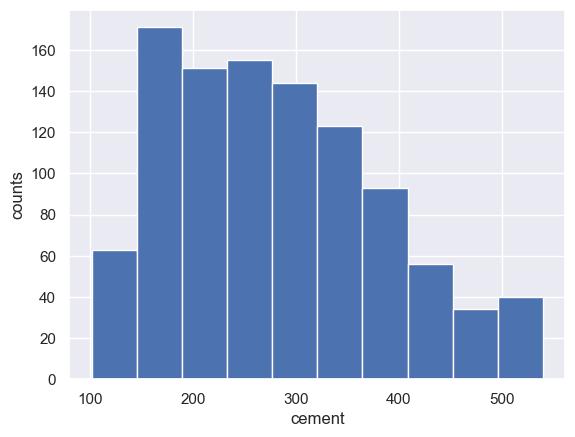

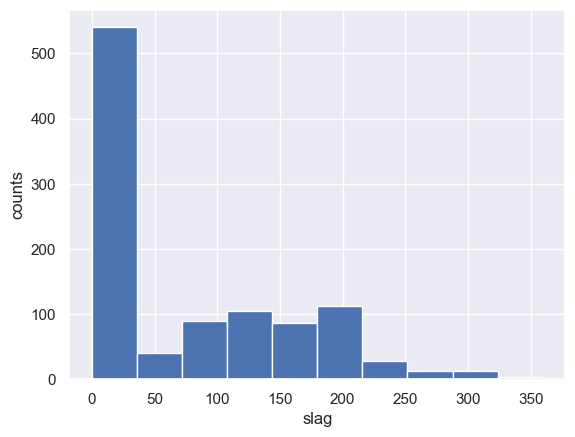

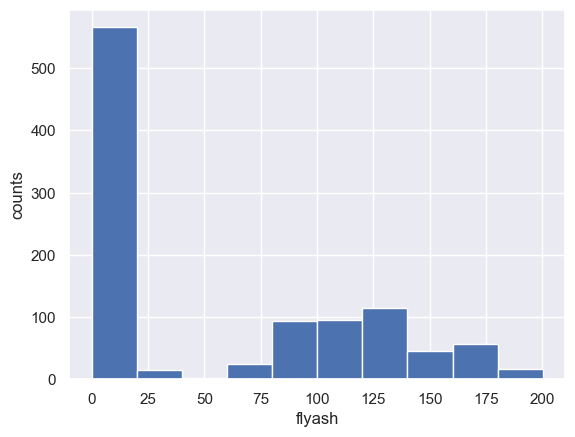

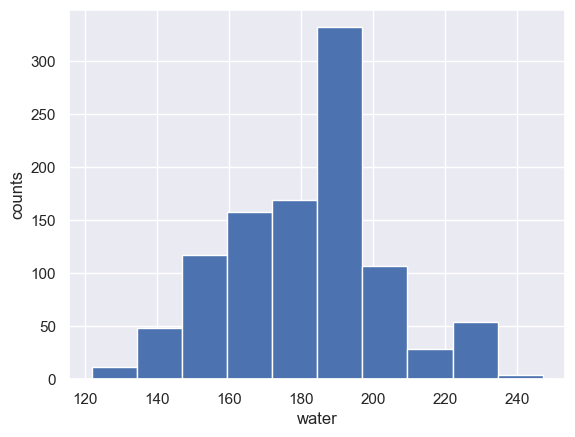

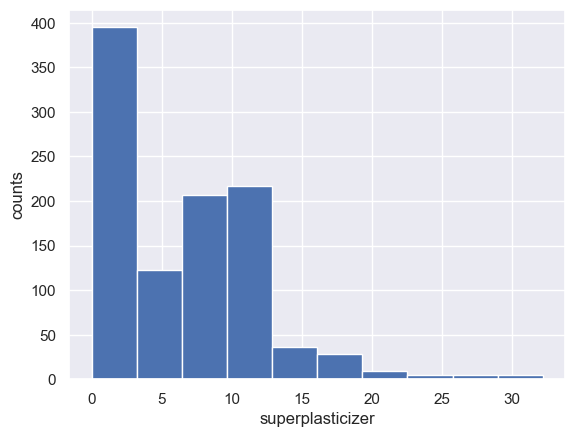

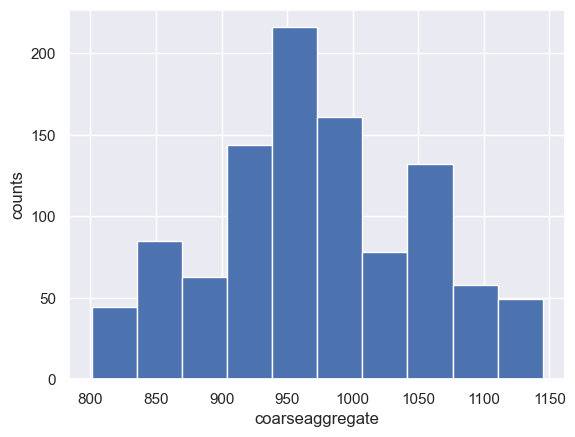

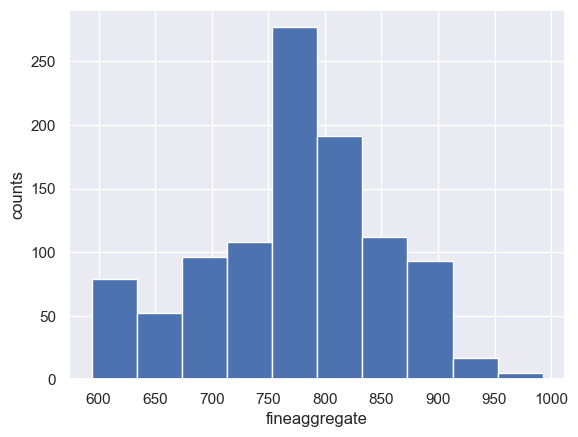

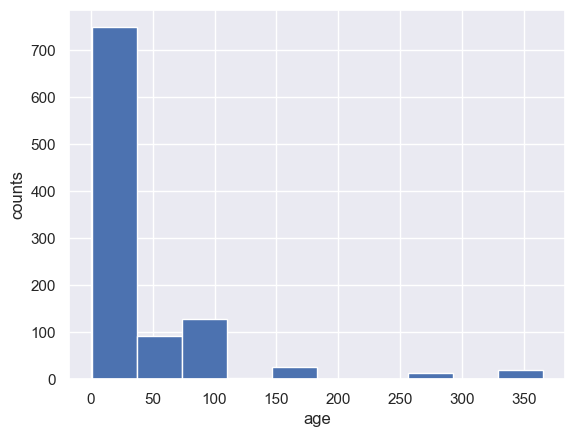

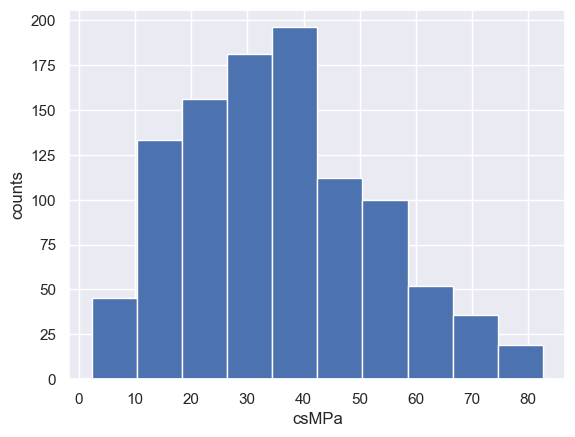

In [7]:
#look at data distribution
for i in concrete_data.columns:
    plt.hist(concrete_data[i])
    plt.xticks()
    plt.xlabel(i)
    plt.ylabel('counts')
    plt.show()

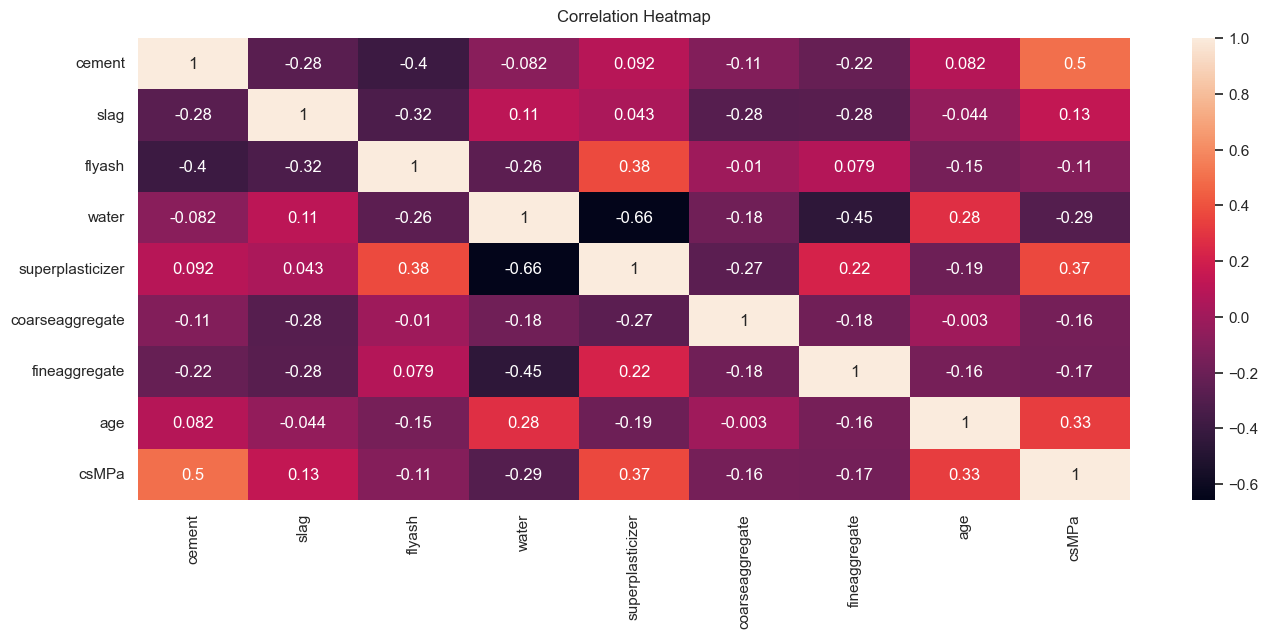

In [8]:
#heat map using Pearson's coefficient
plt.figure(figsize=(16, 6))
sns.heatmap(concrete_data.corr(), annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [9]:
#create bins from compressive strength
bins = pd.qcut(concrete_data['csMPa'], q=4)

#add bins to concrete df
concrete_data['bins']=bins

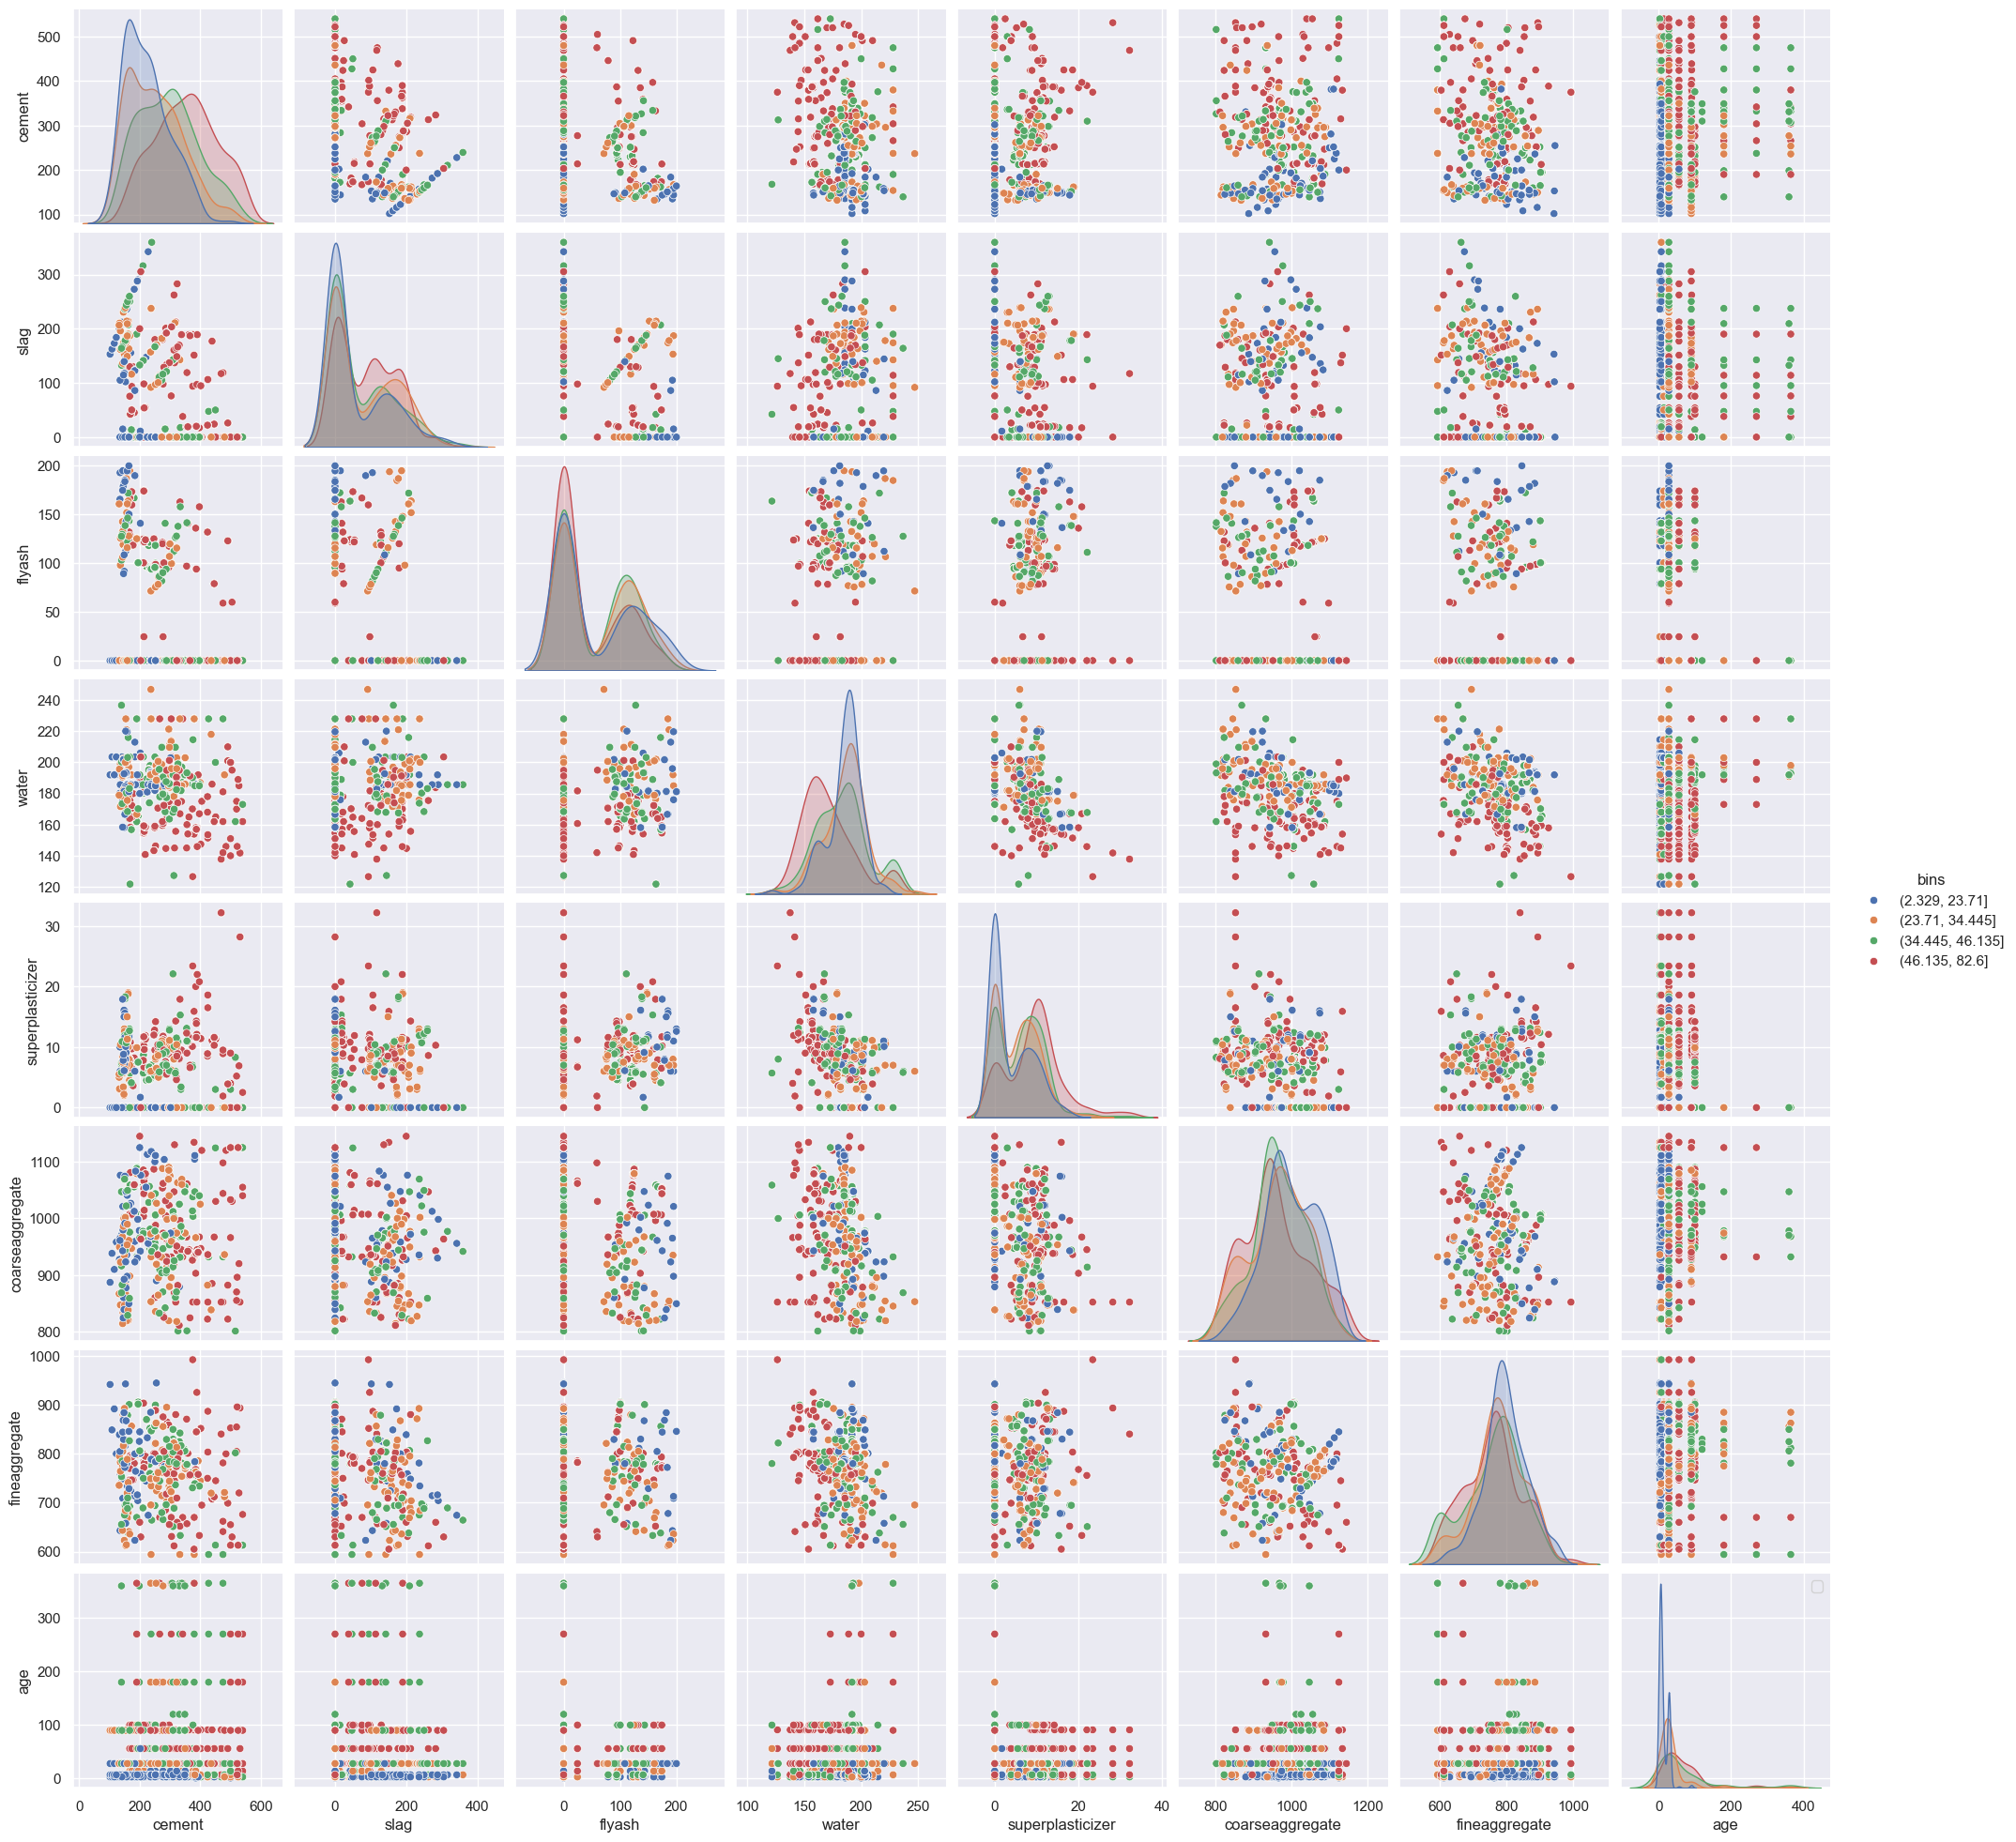

In [10]:
#look at how target is distributed among variables
sns.pairplot(concrete_data.loc[:, (concrete_data.columns != 'csMPa')], hue='bins')
plt.legend()
plt.show()

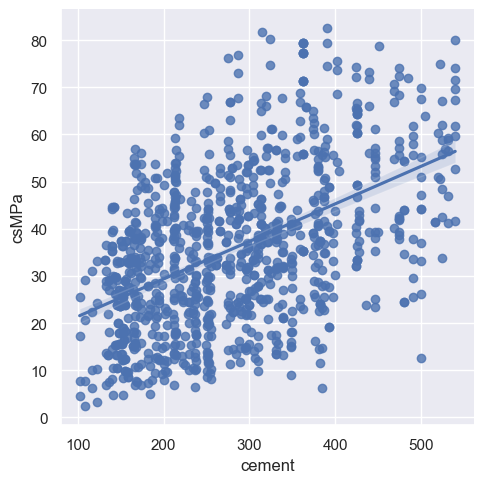

In [11]:
#plot strongest linear correlation
sns.lmplot(x='cement', y='csMPa',data=concrete_data)
plt.show()

In [12]:
#drop bins from concrete data
concrete_data = concrete_data.drop('bins', axis=1)

In [13]:
#copy of variables and target
X = concrete_data.copy()
y = X.pop('csMPa')

# 3. Mutual Information

In [14]:
#make a copy of features matrix for mutual information analysis
X_mi = X.copy()

#label encoding for categorical variables
for colname in X_mi.select_dtypes("object"):
    X_mi[colname], _ = X_mi[colname].factorize()

#all discrete features have int dtypes
discrete_features = X_mi.dtypes == object

In [15]:
#some continuous variables also have int dtypes
discrete_features[X_mi.columns] = False

In [16]:
#use regression since the target variable is continuous
from sklearn.feature_selection import mutual_info_regression

#define a function to produce mutual information scores
def make_mi_scores(X_mi, y, discrete_features):
    mi_scores = mutual_info_regression(X_mi, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#compute mutual information scores
mi_scores = make_mi_scores(X_mi, y, discrete_features)
mi_scores

age                 0.356641
water               0.351567
cement              0.307851
coarseaggregate     0.255012
fineaggregate       0.211478
superplasticizer    0.210757
slag                0.178993
flyash              0.121506
Name: MI Scores, dtype: float64

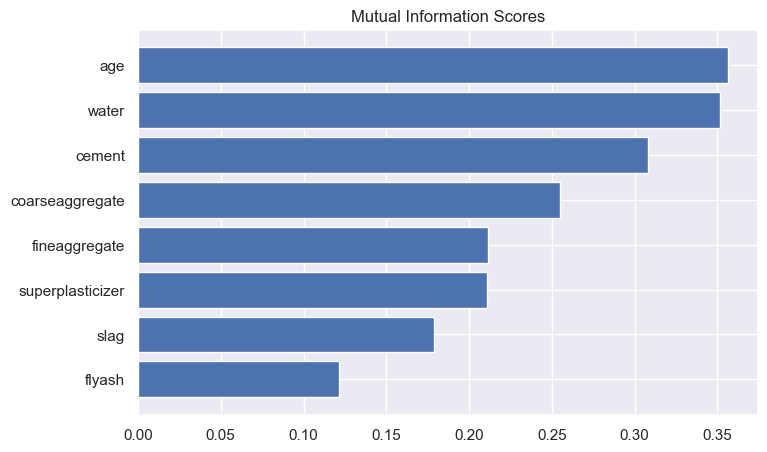

In [17]:
#define a function to plot mutual information scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

#plot the scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

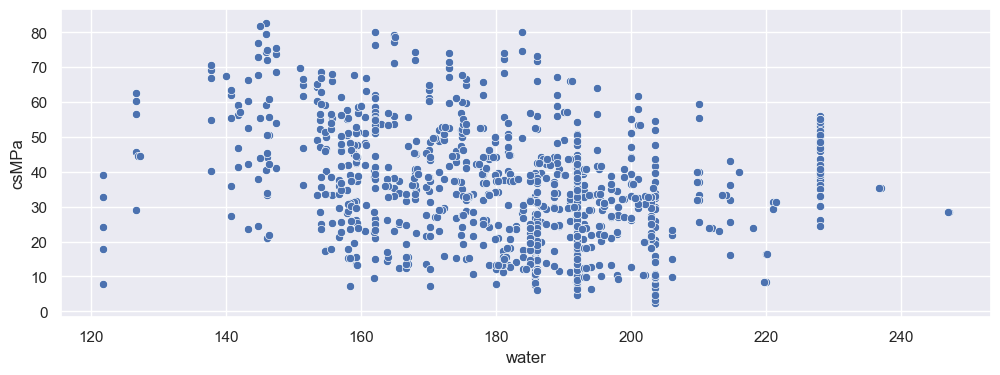

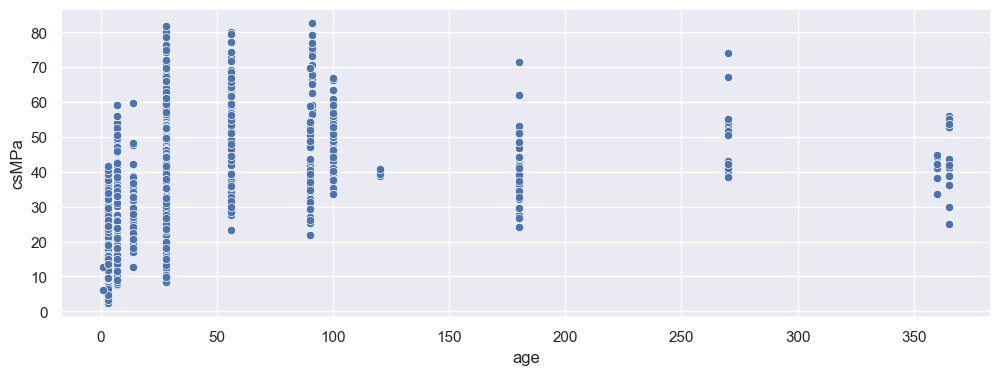

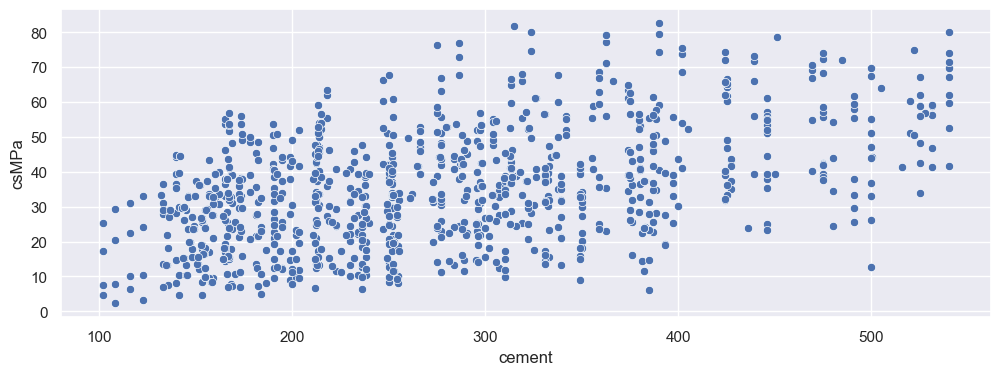

In [18]:
#plot top MI score predictors against target
for i in ['water', 'age', 'cement']:
    fig, ax = plt.subplots(figsize=(12,4))
    sns.scatterplot(x=X_mi[i], y=y, ax=ax)
    plt.show()

# 4. Principal Component Analysis

In [19]:
#copy features matrix for principal component analysis
X_for_PCA = X.copy()

#standardize
X_for_PCA_scaled = (X_for_PCA - X_for_PCA.mean(axis=0)) / X_for_PCA.std(axis=0)

from sklearn.decomposition import PCA

#create principal components
pca = PCA(len(X.columns))
X_pca = pca.fit_transform(X_for_PCA_scaled)

#convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

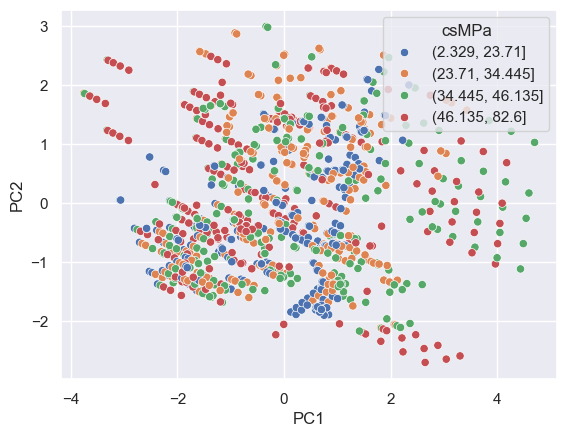

In [20]:
#plot data using principal components
sns.scatterplot(x=X_pca.loc[:,'PC1'],y=X_pca.loc[:,'PC2'], hue=bins)
plt.show()

In [21]:
#determine loadings
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

PC1       PC2       PC3       PC4       PC5       PC6  \
cement            0.098401 -0.113737  0.814202  0.054297 -0.148206 -0.203142   
slag              0.177262  0.686053 -0.171794  0.362699  0.020932  0.304882   
flyash           -0.394662 -0.142948 -0.408221 -0.226751 -0.549631 -0.183267   
water             0.547004  0.053256 -0.213190 -0.296060 -0.070222 -0.365970   
superplasticizer -0.505945  0.282930  0.234597  0.037274 -0.354618  0.193294   
coarseaggregate   0.037928 -0.629943 -0.174088  0.545805  0.033083  0.314559   
fineaggregate    -0.401926 -0.019391 -0.004569 -0.385282  0.701237  0.092466   
age               0.291479 -0.125981  0.100521 -0.527919 -0.228010  0.743908   

                       PC7       PC8  
cement           -0.221844  0.446163  
slag             -0.228363  0.437384  
flyash           -0.352463  0.381886  
water             0.524275  0.388741  
superplasticizer  0.664643  0.051750  
coarseaggregate   0.226840  0.349320  
fineaggregate     0.039026  0.433370  
age              -0.069367  0.012881

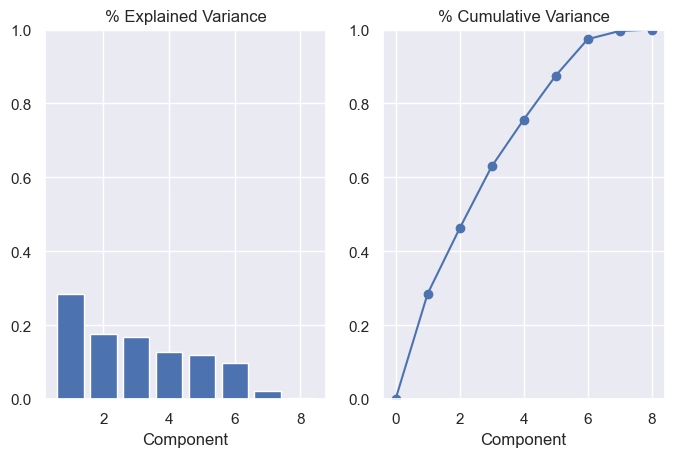

In [22]:
#determine % explained variance and use % cumulative variance for elbow method to determine number of PCs

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca);

# 5. OLS Regression Analysis

In [23]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [24]:
#generate OLS regression results for all features
import statsmodels.api as sm

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     204.3
Date:                Thu, 24 Oct 2024   Prob (F-statistic):          6.29e-206
Time:                        16:18:50   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -23.3312     26.586  

**Question 1: Is there a relationship between the predictors (age and ingredients) and the response variable (compressive strength)?**

Null hypothesis: coefficients for each predictor is zero.

F-statistic = 204.3 >> 1 (suggests at least one of the predictors is related to compressive strength)

Prob(F-statistic) = 6.29e-206 << 0.05 (probability that the null hypothesis is true)

Therefore, there is a relationship between the predictors and the response variable.


**Question 2: How strong is the relationship?**

R-squared = 0.616 (61.6% of variance is explained by the model)


**Question 3: Which predictors contribute to compressive strength?**

Look at the p-values for each t-statistic for each predictor where p-values are the probability of t-statistic given the null hypothesis is true. A probability less than 1/20 (0.05) is considered sufficient to reject the null hypothesis.

All but coarse and fine aggregates are less than 0.05. Therefore, the aggregates do not contribute to compressive strength in this model.


**Question 4: How large is the effect of each predictor on compressive strength?**

The only predictor confidence interval to include zero is coarse aggregate. The rest are considered to be statistically significant. To test whether collinearity is the reason why the confidence interval is so wide for coarse aggregate, the VIF scores are calculated.







In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
#initialize VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
#calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

            feature        VIF
0            cement  15.456717
1              slag   3.329127
2            flyash   4.147833
3             water  82.157569
4  superplasticizer   5.471094
5   coarseaggregate  84.955779
6     fineaggregate  72.790995
7               age   1.699459


The VIF scores exceeding 5 to 10 indicate collinearity (where 1 is the minimum). The aggregates, water, and cement exhibit multicollinearity. Superplasticizer is within the 5 to 10 range, so if being conservative then superplasticizer also demonstrates multicollinearity. Therefore, we cannot say that coarse aggregate is or is not statistically significant, because the wideness of the confidence interval could be due to multicollinearity.

To assess association of each predictor, seperate OLS for each predictor is performed:

In [26]:
#print OLS summary for each feature
for i in X.columns:
    X_sm = sm.add_constant(X[i])
    model = sm.OLS(y,X_sm)
    print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     338.7
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           1.32e-65
Time:                        16:18:50   Log-Likelihood:                -4214.6
No. Observations:                1030   AIC:                             8433.
Df Residuals:                    1028   BIC:                             8443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4425      1.297     10.365      0.0

Looking at the p-value of the t-statistic: all variables have a strong association with compressive strength where fly ash has the weakest by 0.001.


**Question 5: How accurately can this model predict compressive strength?**

The accuracy depends on what type of prediction:

1. Individual response (Y = f(X) + ep), the prediction interval is used
2. Average response (f(X)), the confidence interval is used

Prediction intervals are wider than confidence intervals because the account for the uncertainity associated with the irreducible error (ep).


**Question 6: Is the relationship linear?**

Non-linearity can be determined from residual vs. predicted value plot for each variable (top right plots below). When linearity exists, there should be no clear pattern. The residual plot with the most non-linear form is for age where for ages 0 to 20, there are negative residuals then the residuals increase from 20 to 100 before decreasing again. Water and fine aggregate have slight non-linear patterns. Transformations of the predictors (e.g., sqrt(X), X^2) could accomodate the nonlinearities.

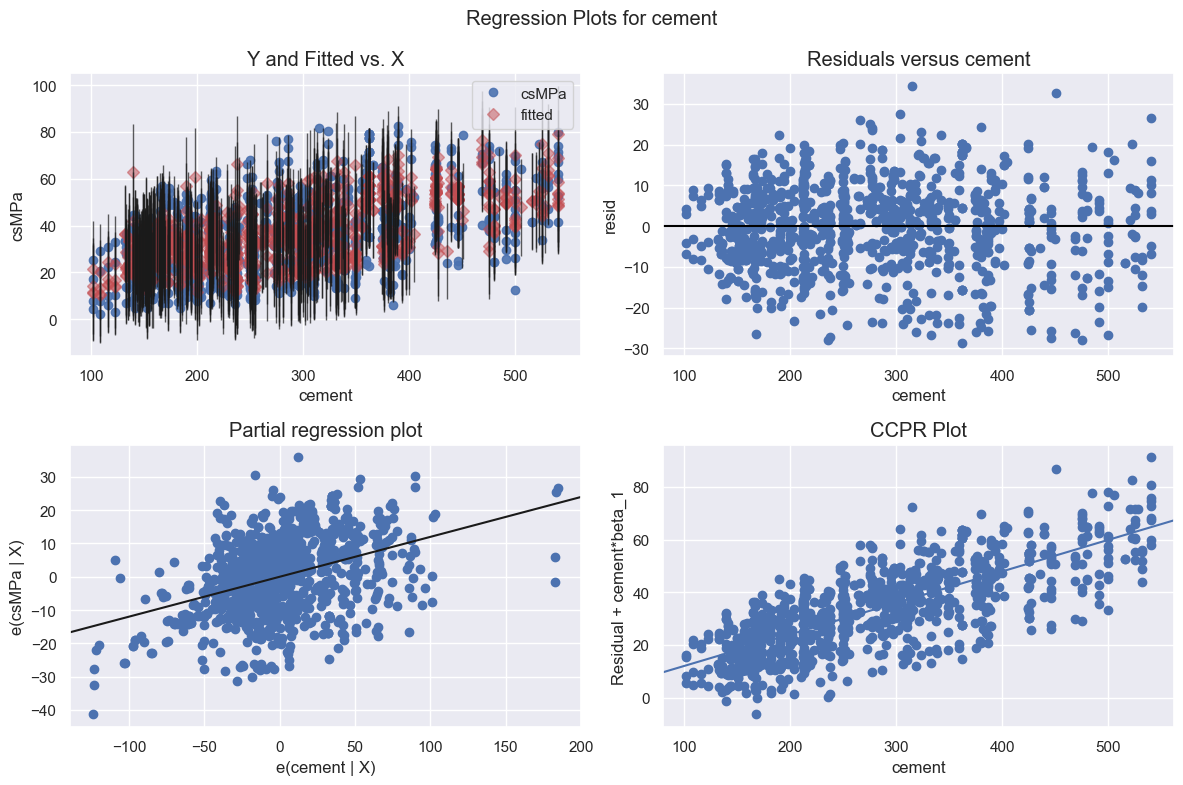

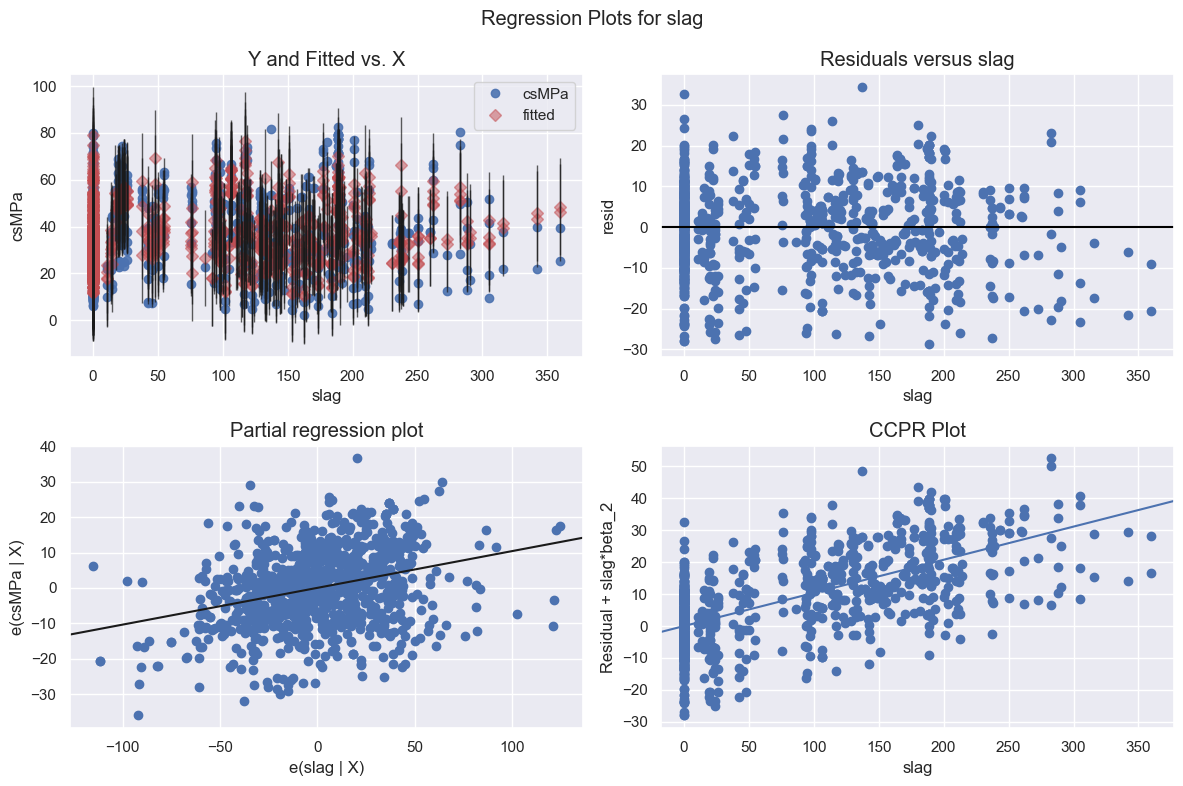

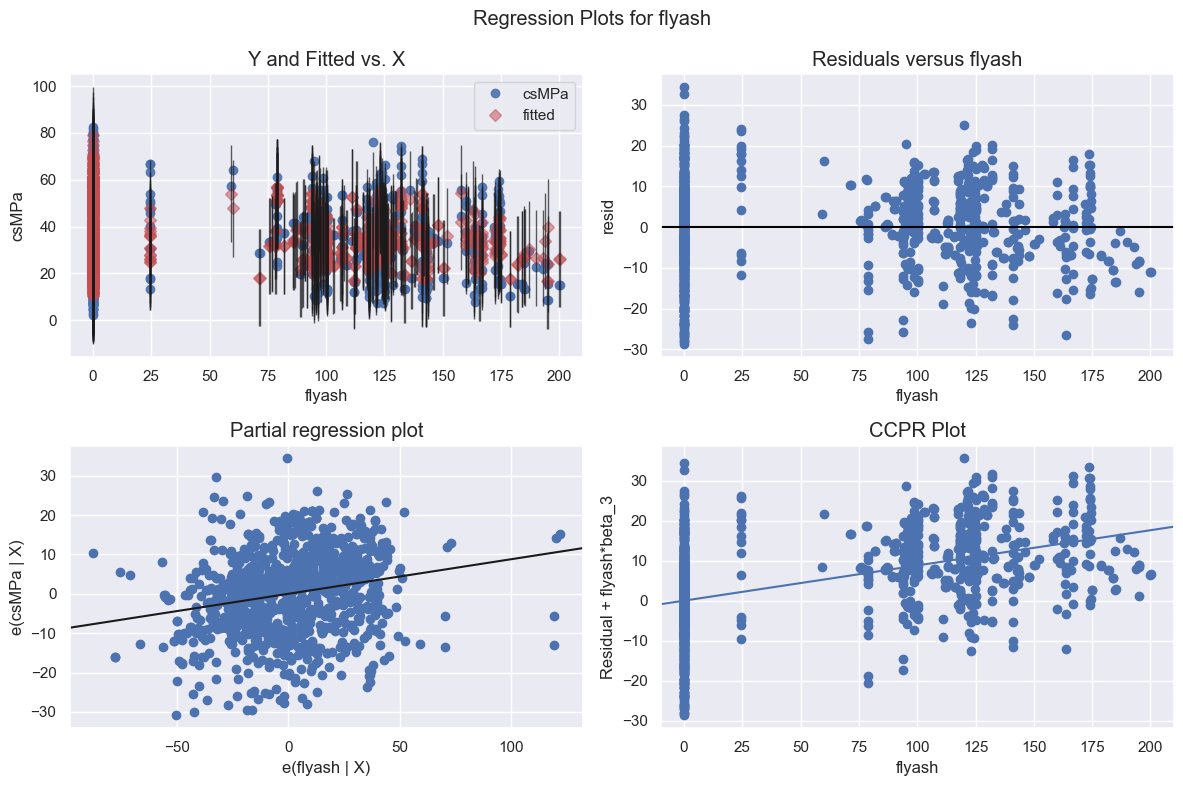

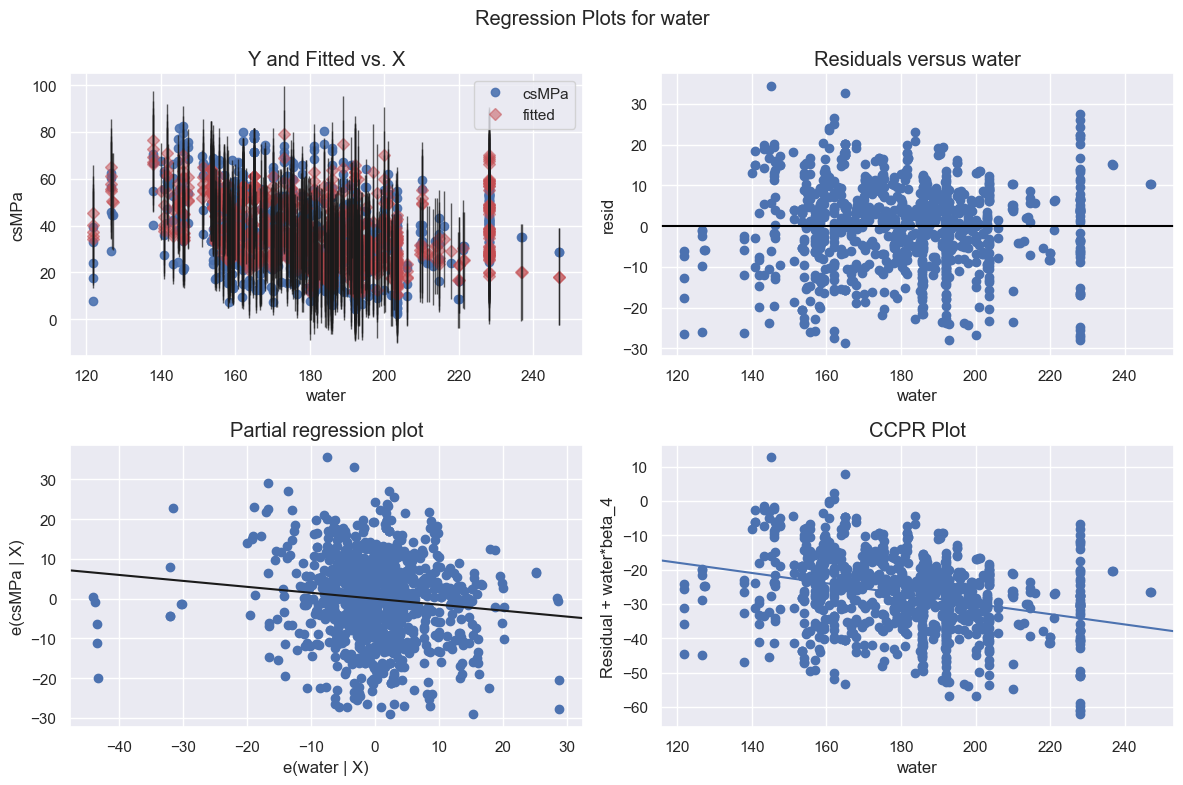

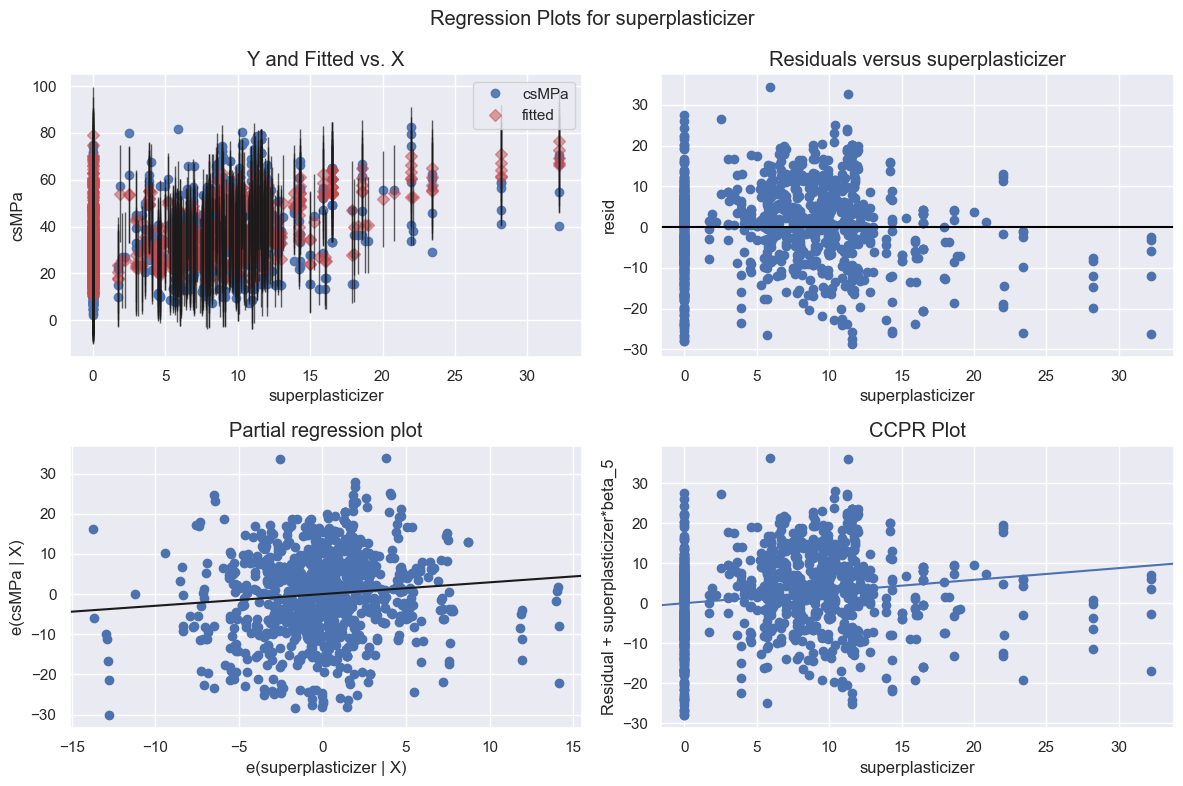

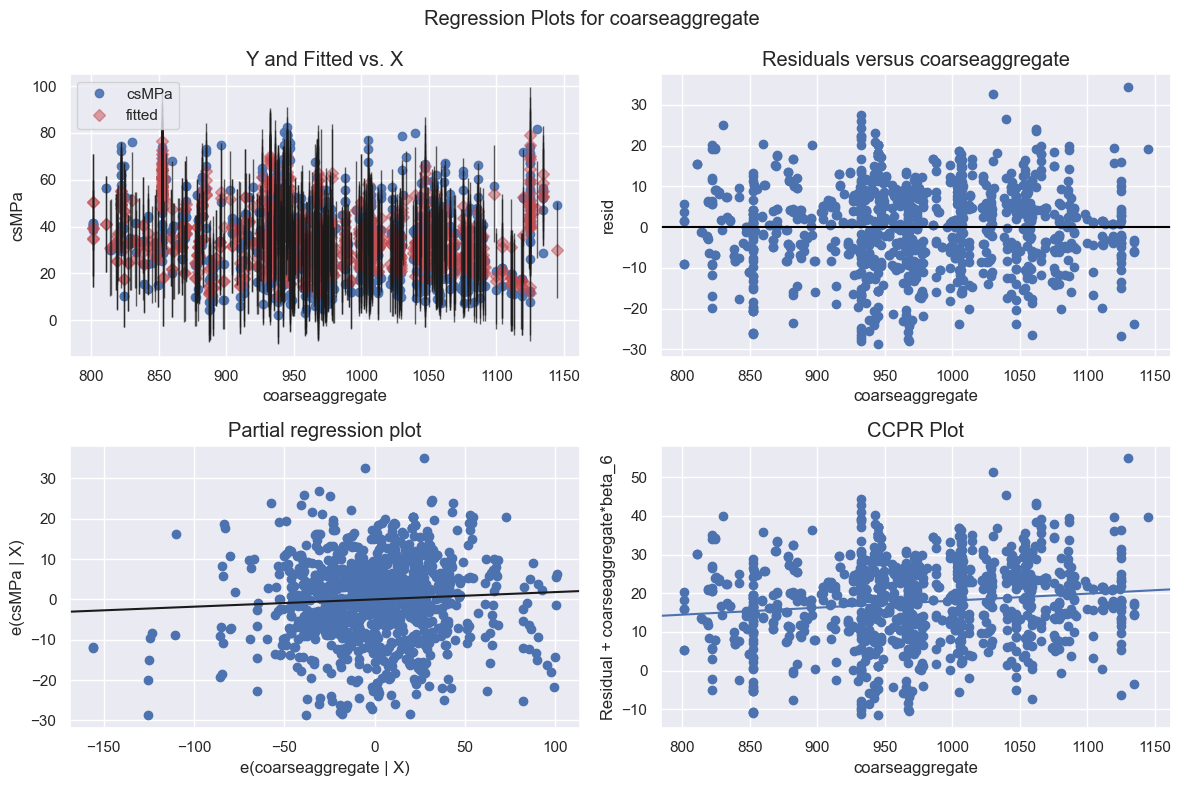

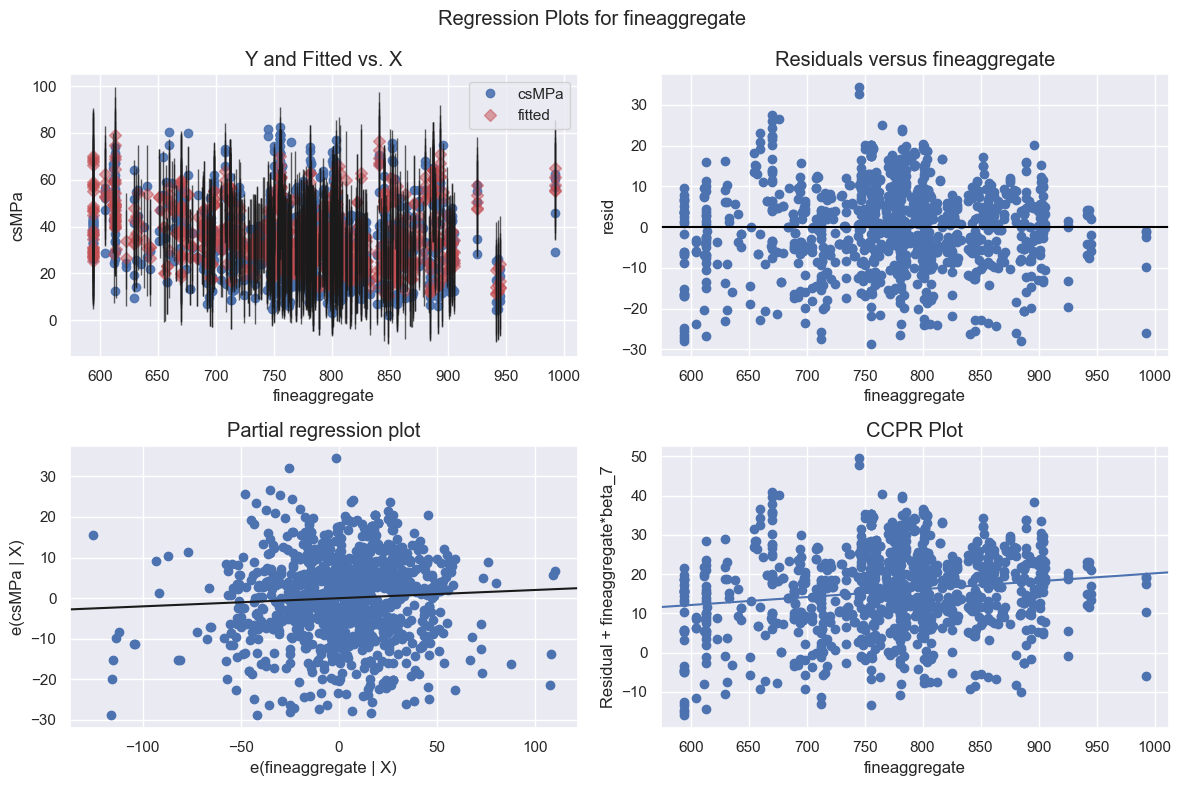

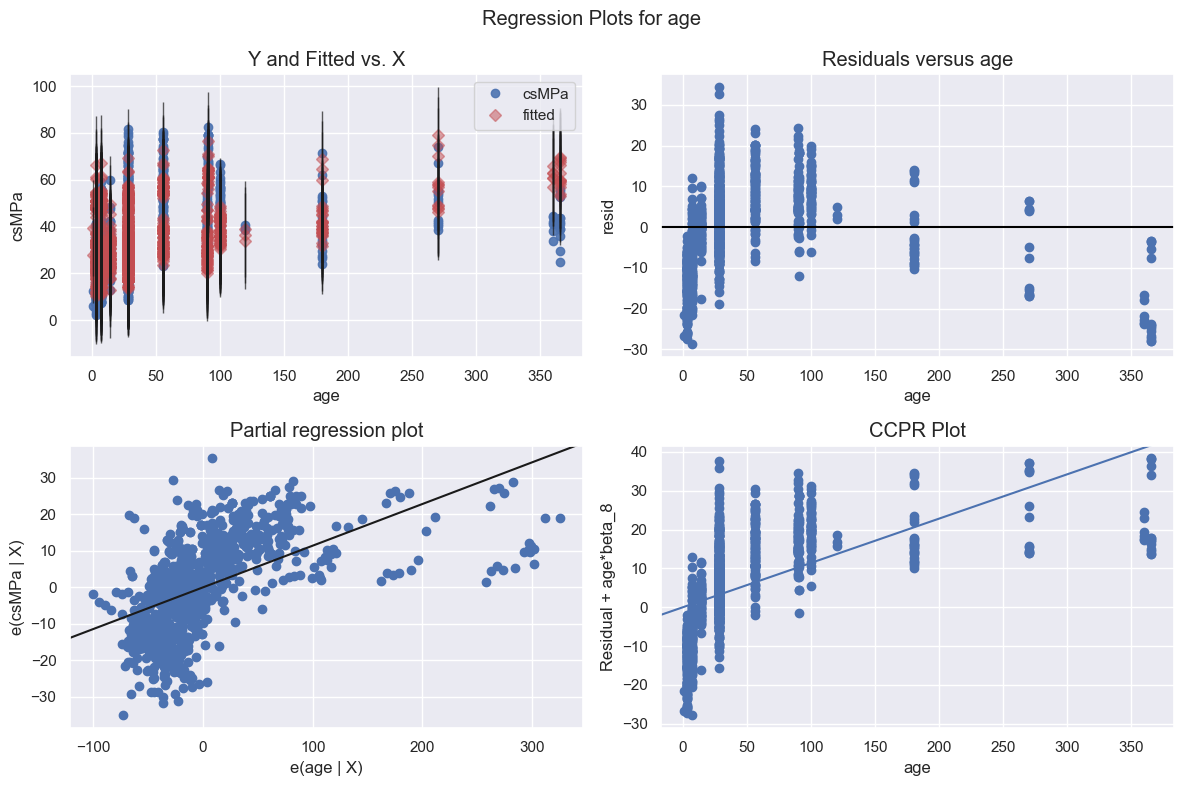

In [27]:
from statsmodels.formula.api import ols

#fit multiple linear regression model
model = ols('csMPa ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age', data=concrete_data).fit()

#create residual vs. predictor plot for 'assists'
for i in X.columns:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(model, i, fig=fig)
    fig.show()

# 6. Feature Engineering with OLS

**Question 7: Is there synergy among the predictors?**

To answer this, an interaction term needs to be created that accomodates non-additive relationships and the R-squared value should increase with this inclusion. Below I have created an interaction term for water and cement (water : cement ratio) and ran an OLS analysis again. With this interaction term, the R-squared term increased from 0.616 to 0.618. Since adding variables increases R-squared automatically and an increase of 0.002 is not large, it's better to look at the adj. R-squared which penalizes additional predictors. This value went from 0.613 to 0.615 indicating synergy exists between these predictors. Similarly, AIC and BIC metrics penalize models with more predictors, but AIC decreased with the addition of water : cement ratio (from 7756 to 7750) and BIC remained the same (7800) further demonstrating that the addition of the predictor is justified. The best method for judgement of the inclusion of this variable is through estimating the test set results through cross-validation, but given the nonlinearity of compressive strength to the predictors, linear regression isn't worth wasting further time on as other non-linear models will produce better predictive results. For inference purposes, adj.-R-squared, BIC, and AIC suffice.

Other interaction terms I tried are cement : fineaggregate, cement : coarseaggregate, cement : fineaggregate : coarseaggregate, and superplasticizer : cement. None of these increased adj. R-squared and their t-statistic p-value were > 0.05.

In [28]:
#feature engineering using knowledge that water:cement ratio is an important factor for concrete strength
X['water_cement_ratio'] = X['water']/X['cement']

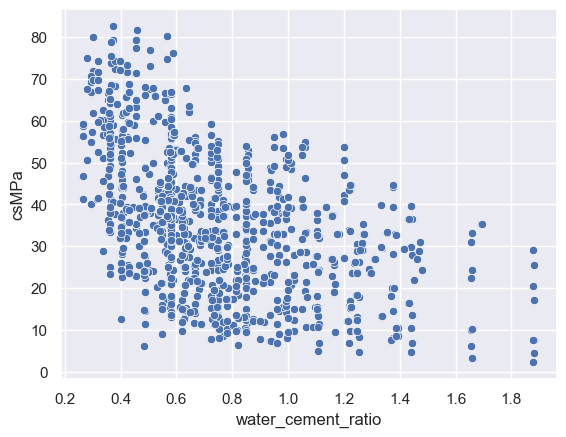

In [29]:
#plot water:cement ratio against compressive strength
sns.scatterplot(x=X['water_cement_ratio'], y=y)
plt.show()

In [30]:
#generate OLS regression results with water : cement ratio
X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     183.6
Date:                Thu, 24 Oct 2024   Prob (F-statistic):          2.28e-206
Time:                        16:19:01   Log-Likelihood:                -3865.2
No. Observations:                1030   AIC:                             7750.
Df Residuals:                    1020   BIC:                             7800.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -16.1769     26

In [31]:
#generate OLS summary with only water : cement ratio
X_sm = sm.add_constant(X['water_cement_ratio'])
model = sm.OLS(y,X_sm)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     343.9
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           1.86e-66
Time:                        16:19:02   Log-Likelihood:                -4212.6
No. Observations:                1030   AIC:                             8429.
Df Residuals:                    1028   BIC:                             8439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 55.7502      1

Looking at the p-value of the t-statistic: water : cement ratio has a strong association with compressive strength.

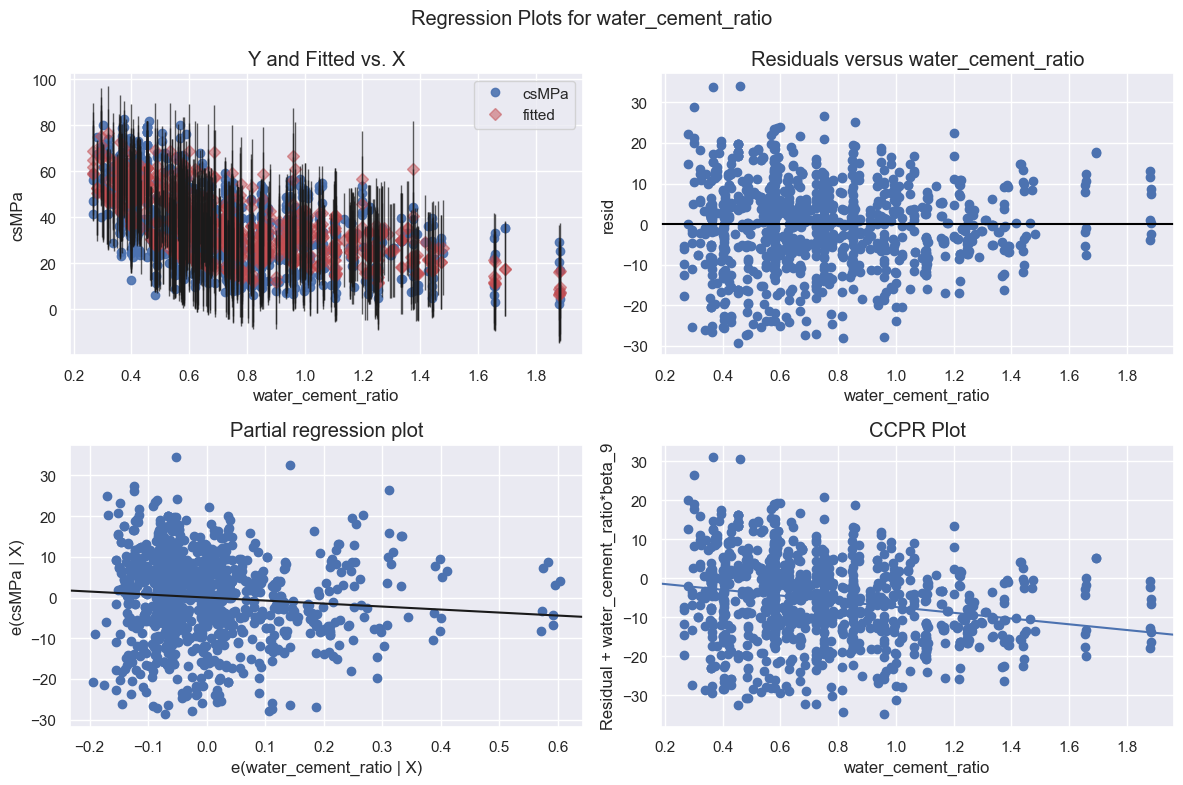

In [32]:
#copy water : cement ratio into concrete data
concrete_data['water_cement_ratio'] = X['water_cement_ratio']

#fit multiple linear regression model with water : cement ratio
model = ols('csMPa ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age + water_cement_ratio', data=concrete_data).fit()

#plot regression plots for water : cement ratio
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'water_cement_ratio', fig=fig)
fig.show()

Water : cement ratio residuals exhibits a near linear relationship.

# 7. Preparing Data for ML

In [33]:
#import ML preprocessing packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [34]:
#column names
feature_names = X.columns

#train/test split 75% training, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=1)

#numerical pipeline
scaler=MinMaxScaler()

#apply scaler to numerical data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 8. ML Baselines

In [35]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [36]:
#import ML packages
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [37]:
#LinearRegression mean cross-validation
lm = LinearRegression()
lm.fit(X_train, y_train)
cv = cross_val_score(lm,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('LinearRegression')
print(mean(cv), '+/-', std(cv))

LinearRegression
-8.07027940327449 +/- 0.9042563541306468


In [38]:
#RandomForestRegressor mean cross-validation
rf = RandomForestRegressor(random_state = 1)
cv = cross_val_score(rf,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('RandomForestRegressor')
print(mean(cv), '+/-', std(cv))

RandomForestRegressor
-3.741303784820554 +/- 0.1746349225638862


In [39]:
#GradientBoostingRegressor mean cross-validation
gbr = GradientBoostingRegressor(random_state = 1)
cv = cross_val_score(gbr,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('GradientBoostingRegressor')
print(mean(cv), '+/-', std(cv))

GradientBoostingRegressor
-3.8930976574254514 +/- 0.14455688824589297


In [40]:
#XGBoost mean cross-validation
xgb = XGBRegressor(random_state = 1)
cv = cross_val_score(xgb,X_train,y_train,scoring='neg_mean_absolute_error',cv=5)
print('XGBoost')
print(mean(cv), '+/-', std(cv))

XGBoost
-3.204958500031502 +/- 0.26753285934522414


# 9. Hyperparameter Tuning

In [41]:
#ml algorithm tuner
from sklearn.model_selection import GridSearchCV

#performance reporting function
def clf_performance(regressor, model_name):
    print(model_name)
    print('Best Score: {} +/- {}'.format(str(regressor.best_score_),str(regressor.cv_results_['std_test_score'][regressor.best_index_])))
    print('Best Parameters: ' + str(regressor.best_params_))

In [42]:
#LinearRegression GridSearchCV
lm = LinearRegression()
param_grid = {
                'fit_intercept':[True,False],
                'copy_X':[True, False]
}
clf_lm = GridSearchCV(lm, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_lm = clf_lm.fit(X_train,y_train)
clf_performance(best_clf_lm,'LinearRegressor')

LinearRegressor
Best Score: -8.060702077432467 +/- 0.884692472287158
Best Parameters: {'copy_X': True, 'fit_intercept': False}


In [43]:
#RanddomForestRegressor GridSearchCV
rf = RandomForestRegressor(random_state = 1)
param_grid = {
                'n_estimators': np.arange(160,200,2) , 
                'bootstrap': [True,False],
#                 'max_depth': [20,30,40],
#                 'max_features': ['auto','sqrt','log2'],
#                  'min_samples_leaf': [2],
#                  'min_samples_split': [6,8,10]
              }
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train,y_train)
clf_performance(best_clf_rf,'RandomForestRegressor')

RandomForestRegressor
Best Score: -3.752174984879036 +/- 0.16962584492518898
Best Parameters: {'bootstrap': True, 'n_estimators': np.int64(192)}


In [45]:
#GradientBoostingRegressor GridSearchCV
gbr = GradientBoostingRegressor(random_state = 1)
param_grid = {
                'n_estimators': [160], 
                'max_depth': [4],
                'max_features': [1, 2, 3, 4,5,6,7,8,9],
                'learning_rate': np.arange(.1,1,.1),
                'alpha': [0.0001],
                'min_samples_leaf': [2],
                'min_samples_split': np.arange(2,6,1)
              }
clf_gbr = GridSearchCV(gbr, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_gbr = clf_gbr.fit(X_train,y_train)
clf_performance(best_clf_gbr,'GradientBoostingRegressor')

GradientBoostingRegressor
Best Score: -3.0432037561383454 +/- 0.20455226262643206
Best Parameters: {'alpha': 0.0001, 'learning_rate': np.float64(0.30000000000000004), 'max_depth': 4, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': np.int64(5), 'n_estimators': 160}


In [46]:
#XGBoost GridSearchCV
xgb = XGBRegressor(random_state = 1)
param_grid = {
#               'nthread':[4],
#               'objective':['reg:linear'],
#               'learning_rate': [0.3],
              'max_depth': [4],
#               'min_child_weight': [1],
#               'subsample': [1],
#               'colsample_bytree': np.arange(0.5,1,0.1),
              'n_estimators': [500]
              }
clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, scoring='neg_mean_absolute_error', n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train,y_train)
clf_performance(best_clf_xgb,'XGBoost')

XGBoost
Best Score: -3.060463101501369 +/- 0.26839577688492133
Best Parameters: {'max_depth': 4, 'n_estimators': 500}


# 10. Assessing Models

In [47]:
#import metrics packages
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [49]:
#GradientBoostingRegressor metrics
gbr = GradientBoostingRegressor(alpha = 0.0001,
                                learning_rate= 0.2,
                                max_depth= 4,
                                max_features=7,
                                min_samples_leaf= 2,
                                min_samples_split= 2,
                                n_estimators= 160,
                                random_state = 1)
gbr.fit(X_train,y_train)
tpred_gbr=gbr.predict(X_test)
print('GradientBoostingRegressor')
print('MSE: {}'.format(mean_squared_error(y_test,tpred_gbr)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,tpred_gbr))))
print('MAE: {}'.format(mean_absolute_error(y_test,tpred_gbr)))
print('R-squared: {}'.format(r2_score(y_test,tpred_gbr)))

GradientBoostingRegressor
MSE: 20.129722402356528
RMSE: 4.486615918747283
MAE: 3.0653270781696684
R-squared: 0.9245338231048355


In [50]:
#XGBoost metrics
xgb = XGBRegressor(max_depth=4,
                   n_estimators=500,
                   random_state = 1)
xgb.fit(X_train,y_train)
tpred_xgb=xgb.predict(X_test)
print('XGBoost')
print('MSE: {}'.format(mean_squared_error(y_test,tpred_xgb)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test,tpred_xgb))))
print('MAE: {}'.format(mean_absolute_error(y_test,tpred_xgb)))
print('R-squared: {}'.format(r2_score(y_test,tpred_xgb)))

XGBoost
MSE: 19.684504949748604
RMSE: 4.436722320559244
MAE: 2.9896385412622792
R-squared: 0.9262029399641614


# 11. Feature Importance

In [54]:
pip install distutils

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement distutils (from versions: none)
ERROR: No matching distribution found for distutils


In [1]:
#import packages for explaining feature importance
import eli5
from eli5.sklearn import PermutationImportance

ModuleNotFoundError: No module named 'distutils'

In [47]:
#permutation importance from xgboost
perm = PermutationImportance(xgb).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = list(feature_names), top=len(feature_names))